# Graficador
Gráfico de los resultados. Análisis TO-DO


Agrego la comparacion con t_laser



*Hacer animación de la densidad cada delta t
*Graficar el "perfil de densidad" definido como un promedio en ángulo Tita
*Comparar con la densidad n(r) de Bunkin
*Calcular el campo eléctrico generado. Hacer un gráfico de un campo vectorial
*Modificar el código para estudiar la dependencia con w_ea, I (intensidad del haz)
*¿Cómo se comparan los tiempos característicos (tiempo para llegar a n_max) con Bunkin? Para esto debería partir de una única partícula
Estudiar transitorio y estacionario por separado




Encontré cualitativamente que si I = I_th disminuye el nro de partículas por más que w_ae sea del orden 2e-3. Tendría que verificar cuantitativamente este resultado.



El paso de 3200 a 6400 tomó 1.30 min.s en mi pc. En el siguiente paso me dio un error
MemoryError: Unable to allocate 1.22 GiB for an array with shape (12800, 12800) and data type float64
El mismo paso tomó 48 s en Google Colab
El mismo paso tomó 21 s en Google Colab usando cupy. En el siguiente paso me dio un error de "OutOfMemoryError: Out of memory allocating 1,310,720,000 bytes (allocated so far: 15,515,209,216 bytes)"


Analizando la trayectoria de una única partícula encontré varios problemas
(1) La energía adimensional de la partícula disminuye en el tiempo pero debería aumentar porque la potencia suministrada por el láser es positiva. Creo que esto se debe a que el método de Euler Implícito no conserva energía. Esto da a entender que cuando analizábamos muchas partículas, el aumento de energía se debía más a problemas en la acomodación de la nueva partícula en el choque a que aumente por el láser.
El problema entonces es que si queremos analizar la evolución tenemos que usar, por ejemplo, el método de Crank-Nicholson que creo que conserva la energía. Pero el precio a pagar es que termina siendo muy caro el proceso. Además, sabemos que cuando lleguemos a muchas partículas vamos a tener problemas en la determinación de la energía.

Hablé con Esteban y Franco
Este problema ya debe haber sido resuelto. Buscar libros, repasar Verlet de FISCOM.

Antes ver si encuentro algún método que me de el aumento de potencia que yo busco para una única partícula





Voy a usar el método de Verlet para la evolución temporal
Paredes blandas en lugar de paredes rígidas

En el análisis de una única partícula obtenemos que la potencia suministrada por el láser es pequeña, por lo que aumenta muy de a poco la energía. Entonces, si queremos hacer la evolución total del sistema de partículas nos va a tomar mucho tiempo. Lo que podemos hacer es calcular la potencia suministrada experimentalmente y la frecuencia de colisión de una partícula con la pared. Decir que en /\t la energía de la partícula aumenta en Delta pero tiene una probabilidad w_ae*/\t (o algo así) de terminar adherida. Entonces, avanzamos de a pasos grandes dados por el aumento de energía necesario para que la partícula de mayor energía llegue a Delta. Hacer esto involucra rearmar todo el programa... Supongo que el programa actual ya se puede paralelizar para calcular w_ae y la potencia suministrada para 1, 2, ..., n partículas y hacer estadística. En estos casos no se está considerando la posibilidad de adherencia.

Por el resto preguntarle a Fabián

## Importo dependencias

In [26]:
#Importo librerías
import numpy as np
import pickle
import matplotlib.pyplot as plt
import import_ipynb

#Agrego interactividad a los gráficos
%matplotlib ipympl


## Constantes adimensionales

In [27]:
#Constantes matemáticas
pi = np.pi

#Ctes físicas
m = 9.11e-31*1e3 #[g]
e = 1.602e-19*(1/3.336641e-10) #[Fr]
c = 299792458*1e2 #[cm/s]
K = 1.380649e-23*(1/1e-7) #constante de Boltzmann [ergio/K], obtenida de NIST

## Importo datos
(resultados y condiciones iniciales)

In [28]:
archivo_trayectorias = "resultados/trayectorias.npy"
archivo_tiempos = "resultados/tiempos.npy"
archivo_condiciones_iniciales = "resultados/condiciones_iniciales.npy"

# archivo_trayectorias = "resultados/trayectorias_tgrande.npy"
# archivo_tiempos = "resultados/tiempos_tgrande.npy"
# archivo_condiciones_iniciales = "resultados/condiciones_iniciales_tgrande.npy"



datos = np.load(archivo_trayectorias,allow_pickle=True)
rx_vec, ry_vec, vx_vec, vy_vec, = datos[0], datos[1], datos[2], datos[3]

tiempos = np.load(archivo_tiempos, allow_pickle=True)
t, dt, n_pasos, guardo_cada = tiempos[0], tiempos[1], tiempos[2], tiempos[3]
t_vec = np.arange(0, dt*n_pasos, guardo_cada*dt)

cond_ini = np.load(archivo_condiciones_iniciales, allow_pickle = True)
R0, v0, R0_dim, v0_dim = cond_ini[0], cond_ini[1], cond_ini[2], cond_ini[3]
# alpha, beta, gamma, epsilon = cond_ini[2], cond_ini[3], cond_ini[4], cond_ini[5]
# w_ae = cond_ini[6]
# Pot_laser, w = cond_ini[7], cond_ini[8]

In [29]:
#C++
file_x = "resultados/cpp_pos_x.txt"
file_y = "resultados/cpp_pos_y.txt"
file_vx = "resultados/cpp_vel_x.txt"
file_vy = "resultados/cpp_vel_y.txt"
file_t = "resultados/cpp_t.txt"
file_cond_ini = "resultados/cpp_cond_ini.txt"

rx_vec = np.loadtxt(file_x)
ry_vec = np.loadtxt(file_y)
vx_vec = np.loadtxt(file_vx)
vy_vec = np.loadtxt(file_vy)
t_vec = np.loadtxt(file_t)
cond_ini = np.loadtxt(file_cond_ini)
R0, v0, R0_dim, v0_dim = cond_ini[0], cond_ini[1], cond_ini[2], cond_ini[3]

## Gráficos

In [30]:
print("Hay N = ", len(rx_vec[0]), "partículas")
N = len(rx_vec[0])
n_pasos = len(rx_vec)

Hay N =  3 partículas


### Trayectorias

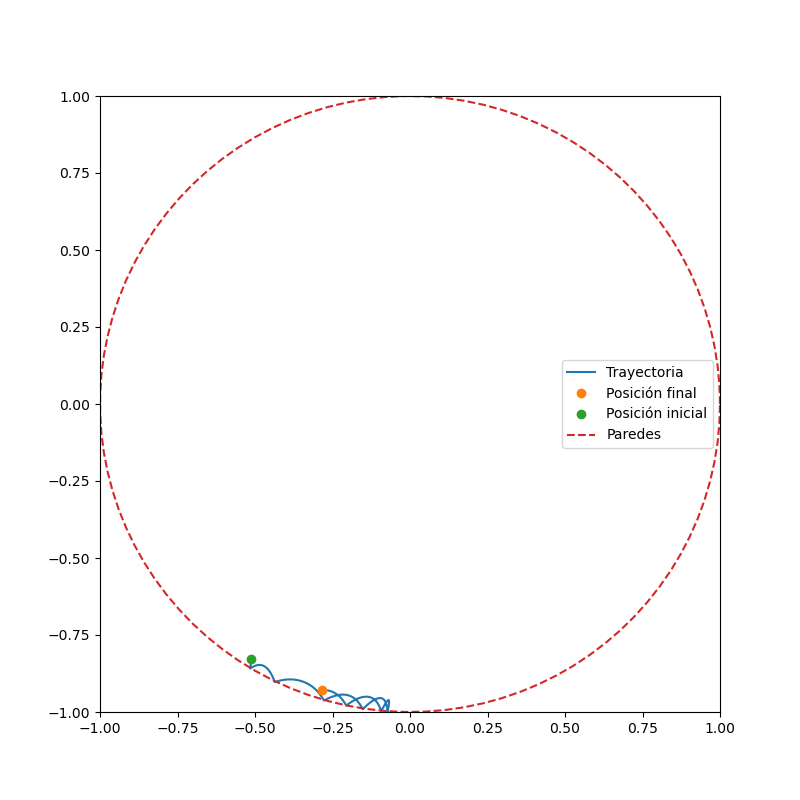

In [31]:


#Grafico la trayectoria desde el momento en el que rx_vec y ry_vec dejan de ser ambos nulos
def trayectoria(rx_vec_i, ry_vec_i, vx_vec_i, vy_vec_i):
    #Corte inferior
    for i in range(len(rx_vec_i)):
        if rx_vec_i[i] != 0 and ry_vec_i[i] != 0 and i != len(rx_vec_i[:])-1:
            rx_graph = rx_vec_i[i:]
            ry_graph = ry_vec_i[i:]
            vx_graph = vx_vec_i[i:]
            vy_graph = vy_vec_i[i:]
            break
        if i == len(rx_vec_i)-1:
            rx_graph = np.zeros(1)
            ry_graph = np.zeros(1)
            vx_graph = np.zeros(1)
            vy_graph = np.zeros(1)
        
    #Corte superior
    for i in range(1,len(rx_graph)):
        if rx_graph[-i] != 0 and ry_graph[-i] != 0:
            rx_graph = rx_graph[:-i]
            ry_graph = ry_graph[:-i]
            vx_graph = vx_graph[:-i]
            vy_graph = vy_graph[:-i]
            break

    
    return rx_graph, ry_graph, vx_graph, vy_graph
    # return rx_graph, ry_graph, vx_graph, vy_graph


#En sufico _analisis_trayectoria se observa que las siguientes partículas escapan. Pero no por un problema en la barrera, sino durante la evolución en la sección interna.
#189, 192, 197
particula = 2 #32
rx_graph, ry_graph, vx_graph, vy_graph = trayectoria(rx_vec[:,particula], ry_vec[:,particula], vx_vec[:,particula], vy_vec[:,particula])
# print(vx_graph)


#Grafico
fig, ax = plt.subplots(figsize=(8,8))
index_ini = 0
index_fin = -1
# index_ini = 0
# index_fin = 1000
ax.plot(rx_graph[index_ini:index_fin],ry_graph[index_ini: index_fin],"-",label="Trayectoria")
ax.plot(rx_graph[-1],ry_graph[-1],"o",label="Posición final")
ax.plot(rx_graph[0],ry_graph[0],"o",label="Posición inicial")
ax.plot(R0*np.cos(np.linspace(0,2*pi,100)),R0*np.sin(np.linspace(0,2*pi,100)),"--",label="Paredes")
plt.legend()
ax.set_xlim([-R0,R0])
ax.set_ylim([-R0, R0])
plt.show()


In [32]:
#Calculo la frecuencia de colisión con la pared
def freq_colisiones(t_total, rx_vec, ry_vec, vx_vec, vy_vec, particula):
    
    rx_graph, ry_graph, vx_graph, vy_graph = trayectoria(rx_vec[:,particula], ry_vec[:,particula], vx_vec[:,particula], vy_vec[:,particula])

    #Calculo la componente radial de la velocidad
    tita_vec = np.arctan2(ry_graph, rx_graph)
    v_radial = vx_graph*np.cos(tita_vec) + vy_graph*np.sin(tita_vec)

    #Calculo la frecuencia de colisión
    nro_colisiones = 0
    for i in range(len(rx_graph)-1):
        if v_radial[i]*v_radial[i+1] < 0: #Hubo un cambio de signo
            nro_colisiones += 1
            print(f"Colisión a tiempo t = {dt*i}")
    return nro_colisiones/t_total

f = freq_colisiones(t_vec[-1], rx_vec, ry_vec, vx_vec, vy_vec, particula)


Colisión a tiempo t = 1e-08
Colisión a tiempo t = 1.3e-07
Colisión a tiempo t = 2.8e-07
Colisión a tiempo t = 4.3e-07
Colisión a tiempo t = 6.5e-07
Colisión a tiempo t = 8.6e-07
Colisión a tiempo t = 1.07e-06
Colisión a tiempo t = 1.28e-06
Colisión a tiempo t = 1.56e-06
Colisión a tiempo t = 1.82e-06
Colisión a tiempo t = 2.05e-06
Colisión a tiempo t = 2.27e-06
Colisión a tiempo t = 2.52e-06
Colisión a tiempo t = 2.74e-06
Colisión a tiempo t = 2.91e-06


In [33]:
#Temperatura

def temperatura(vx_vec, vy_vec):
    '''
    Calculo la temperatura del sistema para cada tiempo
    
    '''
    T_vec = np.zeros(len(vx_vec[:,0]))
    factor = m/3/K*v0_dim**2
    for i in range(len(T_vec)):
        T_vec[i] = np.mean(vx_vec[i,:]**2 + vy_vec[i,:]**2)*factor

    return T_vec


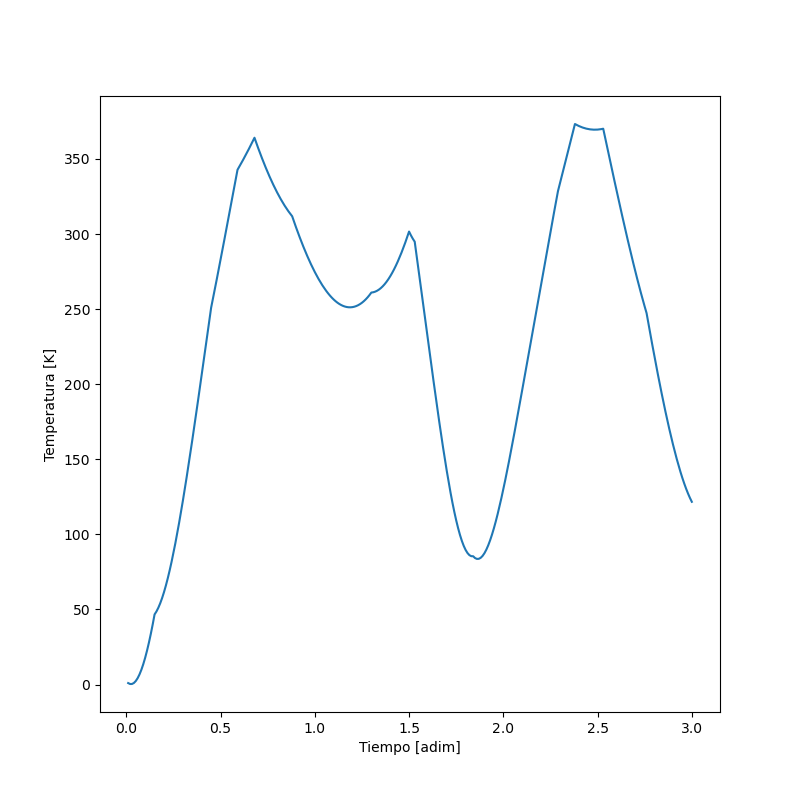

In [34]:
#Grafico
T_vec = temperatura(vx_vec, vy_vec)
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(t_vec, T_vec)
ax.set_xlabel("Tiempo [adim]")
ax.set_ylabel("Temperatura [K]")
plt.show()


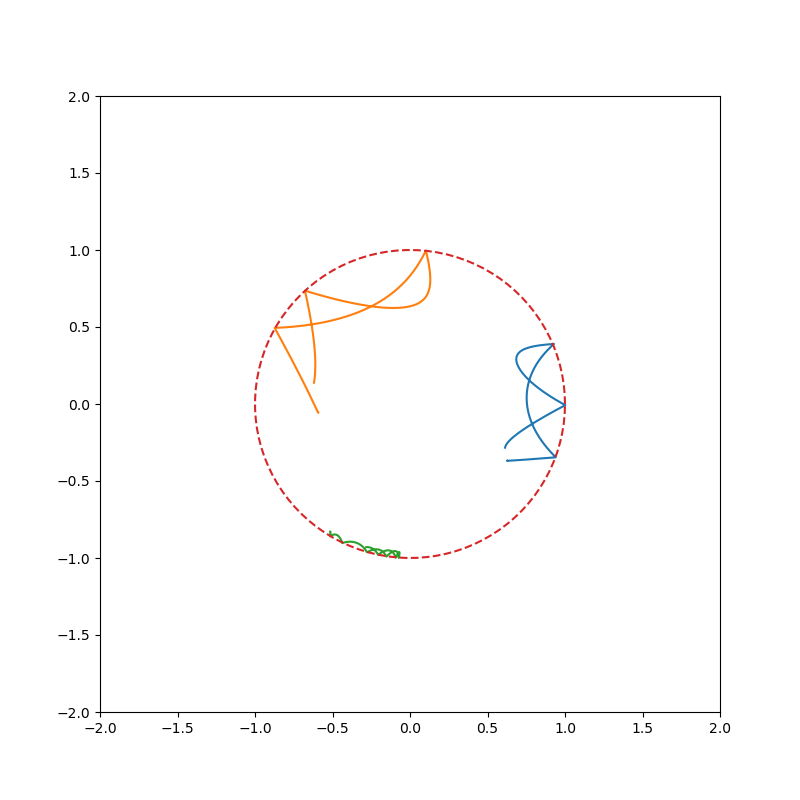

In [35]:
#Grafico varias partículas
fig, ax = plt.subplots(figsize=(8,8))
for i in range(len(rx_vec[0,:])):
    rx_graph_i, ry_graph_i, vx_graph_i, vy_graph_i = trayectoria(rx_vec[:,i], ry_vec[:,i], vx_vec[:,i], vy_vec[:,i])
    ax.plot(rx_graph_i,ry_graph_i,"-")

ax.plot(R0*np.cos(np.linspace(0,2*pi,100)),R0*np.sin(np.linspace(0,2*pi,100)),"--",label="Paredes")
# plt.legend()
ax.set_xlim([-R0*2,R0*2])
ax.set_ylim([-R0*2, R0*2])
plt.show()


In [36]:
# #Busco la partícula que diverge
# for i in range(len(rx_vec[0,:])):
#     rx_graph_i, ry_graph_i, vx_graph_i, vy_graph_i = trayectoria(rx_vec[:,i], ry_vec[:,i])
#     if np.any( rx_graph_i**2 + ry_graph_i**2 > R0**2 ):
#         print("Partícula", i, "diverge")


### Densidad

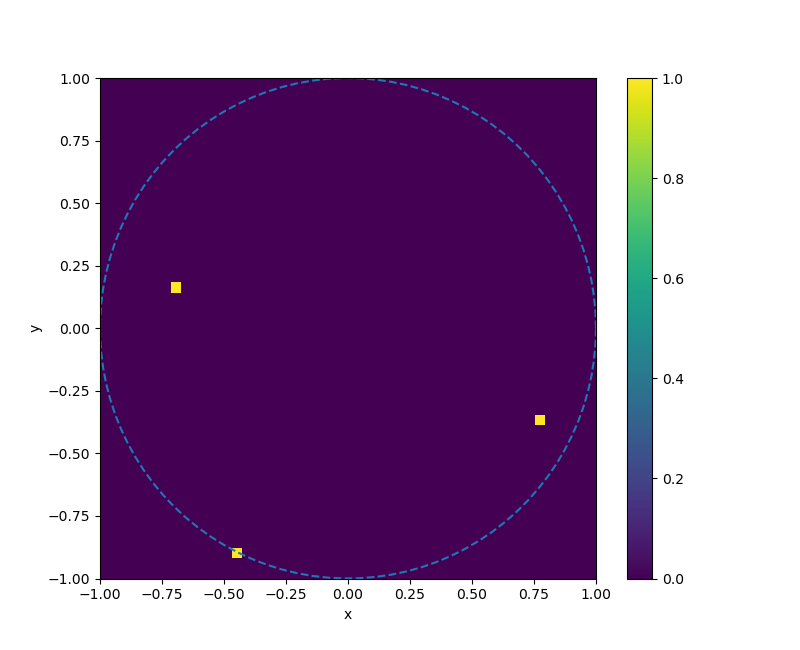

In [37]:
#Para graficar la densidad hago un histograma de las posiciones de las partículas en 2D considerando todas las partículas en un instante de tiempo. Además, las partículas que se encuentren en el origen de coordenadas no contribuyen
# a la densidad, por lo que las elimino del histograma.

t_index = 40

#Defino el binning
bins = np.linspace(-R0,R0,50)
#Defino el histograma
hist, xedges, yedges = np.histogram2d(rx_vec[t_index, :], ry_vec[t_index, :], bins=bins)
#Elimino los datos de [0,0]
threshold = 500
hist[hist >threshold] = 0

#Defino el grid
xgrid, ygrid = np.meshgrid(xedges, yedges)
#Grafico
fig, ax = plt.subplots(figsize=(8,6.5))
#Agrego círculo de radio R0
ax.plot(R0*np.cos(np.linspace(0,2*pi,100)),R0*np.sin(np.linspace(0,2*pi,100)),"--",label="Paredes")
ax.pcolormesh(xgrid, ygrid, hist.T)
ax.set_xlabel("x")
ax.set_ylabel("y")
#Barra de color
cbar = fig.colorbar(ax.pcolormesh(xgrid, ygrid, hist.T))

plt.show()


In [38]:
#Hago una animación del histograma anterior en el tiempo
# from matplotlib import animation

# def animate(i):
#     hist, xedges, yedges = np.histogram2d(rx_vec[i, :], ry_vec[i, :], bins=bins)
#     hist[hist >threshold] = 0
#     ax.clear()
#     ax.plot(R0*np.cos(np.linspace(0,2*pi,100)),R0*np.sin(np.linspace(0,2*pi,100)),"--",label="Paredes")
#     ax.pcolormesh(xgrid, ygrid, hist.T)
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_title("Tiempo = "+str(i))
#     return ax

# print("t0 = ", 0, "\nt_max = ", len(rx_vec[:,0]))

# fig, ax = plt.subplots(figsize=(8,7.5))
# anim = animation.FuncAnimation(fig, animate, frames=len(rx_vec[:,0]), interval=100, blit=False)
# plt.show()


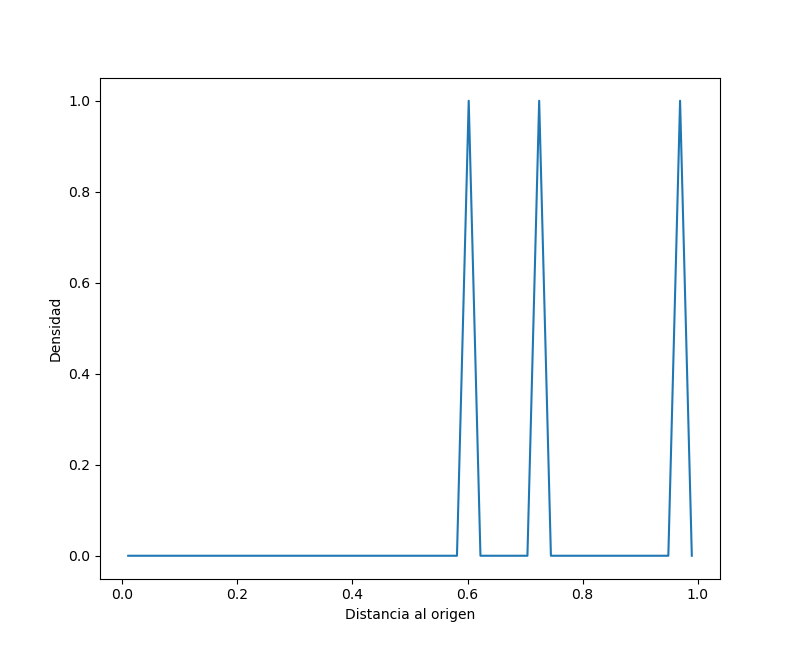

In [39]:
#Grafico el perfil de densidad a un tiempo dado en función de la distancia al origen
t_index = 0


distancias = np.sqrt(rx_vec[t_index,:]**2 + ry_vec[t_index,:]**2)

#Defino el binning
bins = np.linspace(0,R0,50)
#Defino el histograma
hist, xedges = np.histogram(distancias, bins=bins)
#Elimino los datos del origen
hist[0] = 0
#Defino el grid
xgrid = xedges[:-1] + (xedges[1] - xedges[0])/2
#Grafico
fig, ax = plt.subplots(figsize=(8,6.5))
ax.plot(xgrid, hist)
ax.set_xlabel("Distancia al origen")
ax.set_ylabel("Densidad")
plt.show()



In [40]:

def E_pot_i_dim(r_i, rx_vec, ry_vec, R0_dim):
    '''
    Calcula el potencial dimensional en r dadas las posiciones de todas las partículas r_vec y sus cargas adimensionales

    Calcula en r
    Parameters
    ----------

    Returns
    -------
    
    '''
    rx_i = r_i[0]
    ry_i = r_i[1]

    numerador = 1
    denominador = R0_dim*np.sqrt((rx_vec-rx_i)**2 + (ry_vec - ry_i)**2) #distancias
    denominador = denominador[rx_i != rx_vec]

    return e**2*np.sum(numerador/denominador)


def E_cin_i_dim(v_i, v0_dim):
    '''
    Calcula la energía cinética dimensional de la partícula i con velocidad v_i
    
    '''
    vx = v_i[0]
    vy = v_i[1]
    return 1/2*m*v0_dim**2*(vx**2 + vy**2)

def E_total_i_dim(r_i, v_i, rx_vec, ry_vec, v0_dim, R0_dim):
    '''
    Calcula la energía total dimensional en r dadas las posiciones de todas las partículas rx_vec y ry_vec y sus cargas adimensionales
    
    Parameters
    ----------

    Returns
    -------
    
    '''

    return E_cin_i_dim(v_i, v0_dim) + E_pot_i_dim(r_i, rx_vec, ry_vec, R0_dim)

def E_total_dim(rx_vec, ry_vec, vx_vec, vy_vec, v0_dim, R0_dim):
    '''
    Calculo la energía total del sistema
    '''
    E_cin, E_pot = 0, 0
    for i in range(N):
        r_i = np.array([rx_vec[i], ry_vec[i]])
        v_i = np.array([vx_vec[i], vy_vec[i]])
        E_cin += E_cin_i_dim(v_i, v0_dim)
        E_pot += E_pot_i_dim(r_i, rx_vec, ry_vec, R0_dim)

    E_total = E_cin + E_pot/2 #Tengo que dividir por 2 porque consideré cada interacción 2 veces
    
    return E_total, E_cin, E_pot/2


In [41]:
#Energía de la partícula anterior en el tiempo

E_total_dim_vec = np.zeros(n_pasos)
E_cin_dim_vec = np.zeros(n_pasos)
E_pot_dim_vec = np.zeros(n_pasos)

for t in range(n_pasos):    
    E_total_dim_vec[t], E_cin_dim_vec[t], E_pot_dim_vec[t] = E_total_dim(rx_vec[t], ry_vec[t], vx_vec[t], vy_vec[t], v0_dim, R0_dim)
    #Imprimo porcentaje del for
    if t%(n_pasos//50) == 0:
        print("Porcentaje = ", t/n_pasos*100, "%")
        
        

Porcentaje =  0.0 %
Porcentaje =  2.0 %
Porcentaje =  4.0 %
Porcentaje =  6.0 %
Porcentaje =  8.0 %
Porcentaje =  10.0 %
Porcentaje =  12.0 %
Porcentaje =  14.000000000000002 %
Porcentaje =  16.0 %
Porcentaje =  18.0 %
Porcentaje =  20.0 %
Porcentaje =  22.0 %
Porcentaje =  24.0 %
Porcentaje =  26.0 %
Porcentaje =  28.000000000000004 %
Porcentaje =  30.0 %
Porcentaje =  32.0 %
Porcentaje =  34.0 %
Porcentaje =  36.0 %
Porcentaje =  38.0 %
Porcentaje =  40.0 %
Porcentaje =  42.0 %
Porcentaje =  44.0 %
Porcentaje =  46.0 %
Porcentaje =  48.0 %
Porcentaje =  50.0 %
Porcentaje =  52.0 %
Porcentaje =  54.0 %
Porcentaje =  56.00000000000001 %
Porcentaje =  57.99999999999999 %
Porcentaje =  60.0 %
Porcentaje =  62.0 %
Porcentaje =  64.0 %
Porcentaje =  66.0 %
Porcentaje =  68.0 %
Porcentaje =  70.0 %
Porcentaje =  72.0 %
Porcentaje =  74.0 %
Porcentaje =  76.0 %
Porcentaje =  78.0 %
Porcentaje =  80.0 %
Porcentaje =  82.0 %
Porcentaje =  84.0 %
Porcentaje =  86.0 %
Porcentaje =  88.0 %
Porcen

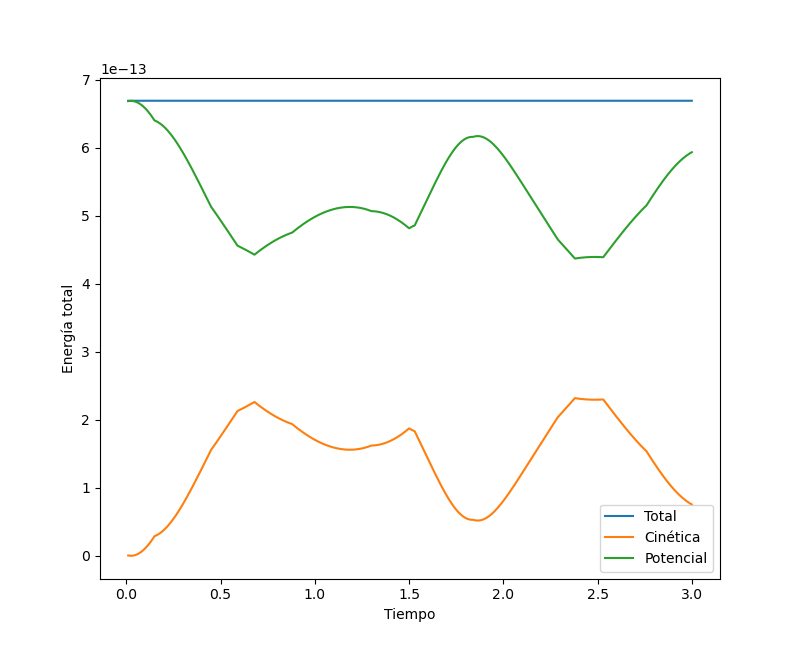

In [42]:
#Grafico
fig, ax = plt.subplots(figsize=(8,6.5))
ax.plot(t_vec, E_total_dim_vec, label = "Total")
ax.plot(t_vec, E_cin_dim_vec, label = "Cinética")
ax.plot(t_vec, E_pot_dim_vec, label = "Potencial")
ax.legend()
ax.set_xlabel("Tiempo")
ax.set_ylabel("Energía total")

plt.show()

In [43]:
error

NameError: name 'error' is not defined

In [ ]:
# #Hago un ajuste lineal de E_total_adim
# from scipy.optimize import curve_fit
# def f(x, a, b):
#     return a*x + b


# y_vec =  E_total_adim_vec#- E_campo_adim_vec

# popt, pcov = curve_fit(f, np.linspace(0,n_pasos, n_pasos), y_vec)
# print("Energía total adimensional = ", popt[0], "* t + ", popt[1])
# print("Pendiende teórica = ", pendiente_teo_adim)

# #Grafico
# fig, ax = plt.subplots(figsize=(8,8))
# ax.plot(y_vec, label = "E_tot/Delta")


# # ax.plot(E_total_adim_vec, label = "E_tot/Delta")
# ax.plot(np.linspace(0,n_pasos, n_pasos), f(np.linspace(0,n_pasos, n_pasos), popt[0], popt[1]), "--", label = "Ajuste lineal")
# ax.legend()
# ax.set_xlabel("Tiempo")
# ax.set_ylabel("Energía adimensional")
# plt.show()



### Número de partículas

In [ ]:
N_vec = np.sum(q_vec, axis=1)
print(len(N_vec) == len(rx_vec[:,0]))

#Grafico la cantidad de partículas en función del tiempo
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(N_vec,"-")
ax.set_xlabel("Tiempo")
ax.set_ylabel("Nro de partículas")
plt.show()



NameError: name 'q_vec' is not defined

### Función de distribución de la energía

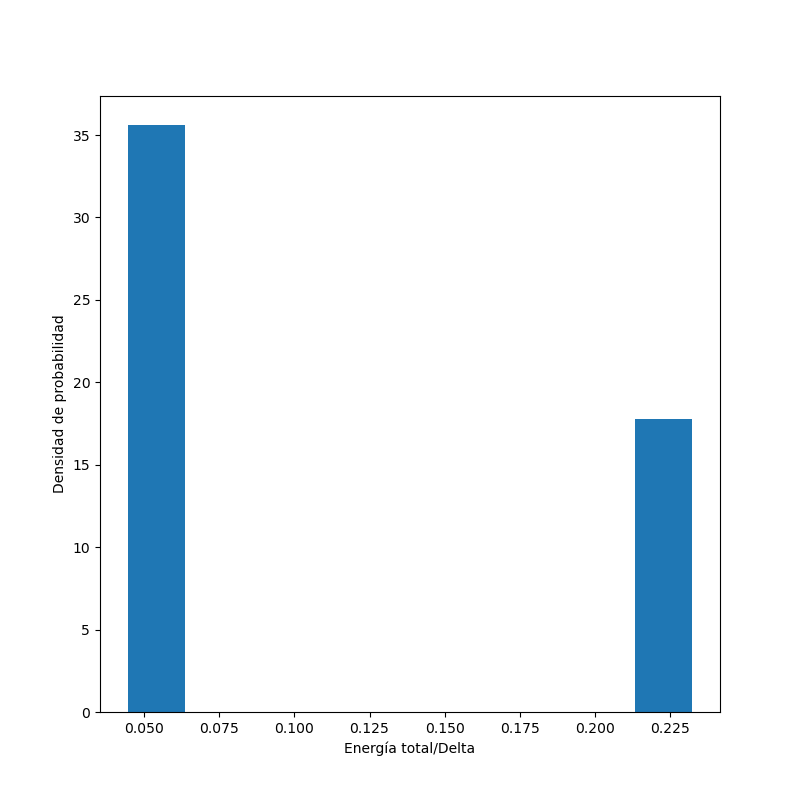

In [ ]:

t = -1

N = len(q_vec[0])
E_total_adim_vec = np.empty(N)

for i in range(N):
    v_i = np.array([vx_vec[t,i], vy_vec[t,i]])
    r_i = np.array([rx_vec[t,i], ry_vec[t,i]])
    r_vec = np.concatenate((rx_vec[t], ry_vec[t]))
    E_total_adim_vec[i] = E_total_dim(r_i, v_i, rx_vec[t], ry_vec[t], q_vec[t], alpha, beta)/Delta

# print(E_total_adim_vec)

#Grafico un histograma normalizado
fig, ax = plt.subplots(figsize=(8,8))
ax.hist(E_total_adim_vec, bins=10, density=True)
ax.set_xlabel("Energía total/Delta")
ax.set_ylabel("Densidad de probabilidad")
plt.show()

In [ ]:
#Hago una animación del histograma anterior en el tiempo

### Potencial eléctrico